In [174]:
import pandas as pd
import numpy as np
import os

import networkx as nx
import re


In [175]:
# importing data

edges = pd.read_csv('data/edges.csv')
nodes = pd.read_csv('data/nodes.csv')
hero_edges = pd.read_csv('data/hero-network.csv')
datasets = [edges, nodes, hero_edges]

In [176]:
# preprocessing
def strip_rightend(string):
    string = string.strip().rstrip('/')

    if string =='SPIDER-MAN/PETER PARKER':
        string = 'SPIDER-MAN/PETER PAR'
    elif string == 'SPIDER-MAN/PETER PARKERKER':
        string = 'SPIDER-MAN/PETER PAR'

    return string

In [177]:
for ds in datasets:
    ds.dropna(inplace=True)
    for col in ds.columns:
        ds[col] = ds[col].apply(lambda row: strip_rightend(row))

In [178]:
hero_edges_arr = np.array(hero_edges)
hero_edges_arr.shape

(574467, 2)

In [179]:
idx_self = np.where(hero_edges_arr[:,0] == hero_edges_arr[:,1])
idx_self
# we check on a sample
hero_edges.iloc[8889]

hero1    MISS AMERICA/MADELIN
hero2    MISS AMERICA/MADELIN
Name: 8889, dtype: object

In [180]:
hero_edges_arr = np.delete(hero_edges_arr, idx_self, axis = 0) # delete the self referring rows by their index
print(hero_edges_arr.shape) # 574467 down to 572235
heroes_df = pd.DataFrame(hero_edges_arr) # ! new df 
heroes_df.columns = ['hero1', 'hero2']

(572235, 2)


creating the hero network graph 

In [181]:
heroes = nx.from_pandas_edgelist(heroes_df, 'hero1', 'hero2', create_using=nx.Graph)

In [264]:
node_count = heroes_df.groupby(['hero1','hero2'])['hero1','hero2'].size()#.apply(lambda row: print(row))

fl = np.power(np.array(list(map(float, node_count.values))), -1)

weights = dict( list(zip (node_count.index, fl) ) )

/var/folders/c0/1q90pl8n3k50gnjpfmzf_lzh0000gn/T/ipykernel_965/1918835698.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  node_count = heroes_df.groupby(['hero1','hero2'])['hero1','hero2'].size()#.apply(lambda row: print(row))


In [267]:
node_tuple_weight = {}
for e in heroes.edges: # 
    try:
        weight = weights[(e[0], e[1])]
    except:
        weight = weights[(e[1], e[0])]

    node_tuple_weight[(e[0], e[1])] = weight

In [268]:
nx.set_edge_attributes(heroes, values = node_tuple_weight, name = 'weight')

creating the comics (& corresponding heroes) graph

In [187]:
node_data = list(zip(nodes.node, [{'tp':t}for t in nodes.type]))
edge_data = list(zip(edges.hero, edges.comic))

In [188]:
# modify edge data to be only included if nodes also in node_data

edge_arr = np.array(edge_data)
print(edge_arr.shape)
node_list = list(nodes.node)

tbd = []

for i in range(len(edge_arr)):
    a, b = edge_arr[i,0], edge_arr[i,1]
    if a not in node_list or b not in node_list:
        tbd.append(i)

edge_arr = np.delete(edge_arr, tbd, axis = 0)
print(edge_arr.shape)

edges_cleaned = pd.DataFrame(edge_arr)
edges_cleaned.columns = ['hero', 'comic'] # needed to establish top hero
# edge_data = [(e[0], e[1])for e in edge_arr.tolist()]
edge_data = list(zip(edges_cleaned.hero, edges_cleaned.comic))

(96104, 2)
(96104, 2)


In [134]:
comics = nx.Graph()
comics.add_nodes_from(node_data)
comics.add_edges_from(edge_data)

In [146]:
# making list of top_n sorted heroes
ls = edges_cleaned.groupby(by = 'hero')['comic'].size().sort_values(ascending=False)
top_n_heroes = np.array(list(zip(ls.index, ls.values)) )

## Functionality 3 - Shortest ordered Route

Input: graph, seq of superheroes h = [h_2, ..., h_n-1]
Initial node h_1 and an end node h_n
N:  top N heroes that their data sh

Output:

The shortest walk of comics that you need to read to get from hero_1 to hero_n
Considerations: For this functionality, you need to implement an algorithm that returns the shortest walk that goes from node h_j to h_n, which visits in order the nodes in h. The choice of h_j and h_n can be made randomly (or if it improves the performance of the algorithm, you can also define it in any other way)

Important Notes:

This algorithm should be run only on the second graph.
The algorithm needs to handle the case that the graph is not connected. Thus, only some of the nodes in h are reachable from h_1. In such a scenario, it is enough to let the program give in the output the string "There is no such path".
Since we are dealing with walks, you can pass on the same node h_i more than once, but you have to preserve order. E.g., if you start from Spiderman to reach deadpool, and your path requires you to visit iron-man and colossus, you can go back to any comics any time you want, assuming that the order in which you visit the heroes is still the same.


In [ ]:
def make_topnhero_graph(comics, N):
    N = 200
    n_heroes = top_n_heroes[:N, 0]

    rel_nodes = list(n_heroes)
    for hero in n_heroes:
        [rel_nodes.append(n) for n in comics.neighbors(hero) if n not in rel_nodes]
    
    sub_comics = comics.subgraph(rel_nodes)

    return sub_comics

In [21]:
def check_if_disconnected(graph, h_0, h_n, hero_seq):
    visited = {}
    for n in graph.nodes():
        visited[n] = False

    visited[h_0] = True
    queue = []
    queue.append(h_0)

    heros = [h_0]+test_hero_seq+[h_n]

    while(len(queue) != 0 and len(heros)>0):
        curr = queue.pop(0)
        if curr in heros:
            heros.remove(curr)

        for n in graph.neighbors(curr):
            if visited[n] == False:
                visited[n] = True
                queue.append(n)
    
    if len(heros)>0:
        return 'heroes not connected'
    

In [165]:
def bfs(sub_comics, visited, seq, h_n):
    visited_cp = visited.copy() # object?
    path_cp = [v for v in visited.keys() if visited[v]==True] # visited.copy()

    queue = []
    for p in path_cp:
        queue.append([p])
    #queue = queue + path_cp # queue.append(path_cp)
    
    while len(queue) != 0:
        curr_a = queue.pop(0) # path to first node considered
        curr = curr_a[-1] # current node
        #print(curr_a)
        #print(curr)
        if curr == h_n:
            return curr_a # actual path of interest
            # break
        
        for n in sub_comics.neighbors(curr):
            if visited_cp[n] == False and n not in seq:
                visited_cp[n] = True
                curr_n = curr_a.copy()
                curr_n.append(n)

                queue.append(curr_n)
     
    return 'heros not connected'+curr+'xxx'+h_n
            


In [171]:
def print_result_fct(sub_comics, paths):
    ordered = []
    [ordered.append(l) for el in paths for l in el if l not in ordered]

    comic_list = [x for x,y in sub_comics.nodes(data=True) if y['tp']=='comic']

    comics_to_read = []
    [comics_to_read.append(n) for n in ordered if n in comic_list]
    print(comics_to_read)
    
    return ordered
    
    

In [169]:
def make_topnhero_graph(comics, N):
    N = 200
    n_heroes = top_n_heroes[:N, 0]

    rel_nodes = list(n_heroes)
    for hero in n_heroes:
        [rel_nodes.append(n) for n in comics.neighbors(hero) if n not in rel_nodes]
    
    sub_comics = comics.subgraph(rel_nodes)

    return sub_comics
    

In [167]:
def functionality3(comics, test_h_seq, v_0, v_n, N):

    sub_comics = make_topnhero_graph(comics, N)
    visited = {}
    for n in sub_comics.nodes():
        visited[n] = False

    paths = []
    doable = True

    #
    v_0 = 'CAPTAIN AMERICA'
    v_n = 'JONES, RICHARD MILHO'
    test_h_seq = ['UATU']
    seq = test_h_seq.copy()
    seq.append(v_n)
    #

    visited[v_0] = True

    while(len(seq)>0): # not all heros visited

        next_h = seq.pop(0) # next superhero to visit
        # print(next_h)
        path_to_next_hero = bfs(sub_comics, visited, seq, next_h)

        if path_to_next_hero == 'heros not connected':
            print(path_to_next_hero)
            doable = False
            break

        for v in path_to_next_hero:
            visited[v] = True
            
        paths.append(path_to_next_hero)

    if doable:
        ordered = print_result_fct(sub_comics, paths)
        return sub_comics, ordered, paths



['A 101', 'A 1']


Drawing the whole graph of top N heros quickly becomes too complex. Even just plotting the nodes of the path and their direct neighbors in a test case resulted in an unexplainable chaos. So I plot just the path-nodes and their neighboring nodes, if these are also direct neighbors of other path-nodes.

In [190]:
# cannot draw all so do another subgraph

tbd_nodes = list(ordered)
for o in ordered:
    [tbd_nodes.append(n) for n in sub_comics.neighbors(o) if n not in tbd_nodes]

tbd_graph = sub_comics.subgraph(tbd_nodes)


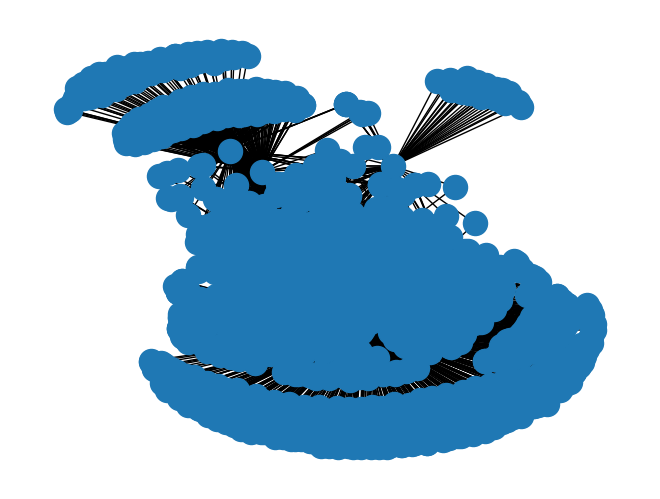

In [193]:
nx.draw(tbd_graph)

In [221]:
tbd_nodes = list(ordered)
for o in ordered:
    [tbd_nodes.append(n) for n in sub_comics.neighbors(o)]

In [222]:
from collections import defaultdict

counter = defaultdict(int)

for tbd in tbd_nodes:
    counter[tbd] += 1

tbd = [k for k, v in counter.items() if v>1]
tbd_graph = sub_comics.subgraph(tbd)


In [236]:
cols = [1 if n in ordered else 0 for n in tbd_graph.nodes()]

path_edges = {}
j = 0
for ed in paths:
    for i in range(len(ed)-1): # should be ok because min len should be 3
        path_edges[(ed[i], ed[i+1])] = j
        j+=1
        
 pos = nx.spring_layout(tbd_graph)
       

{('CAPTAIN AMERICA',
  'A 101'): Text(0.20809053368801303, -0.05670281509875032, '0'),
 ('A 101', 'UATU'): Text(0.408973283139886, -0.34988538369711253, '1'),
 ('CAPTAIN AMERICA',
  'A 1'): Text(-0.08166952672780758, 0.12679512450836897, '2'),
 ('A 1',
  'JONES, RICHARD MILHO'): Text(-0.15242373436337384, 0.17876699506542135, '3')}

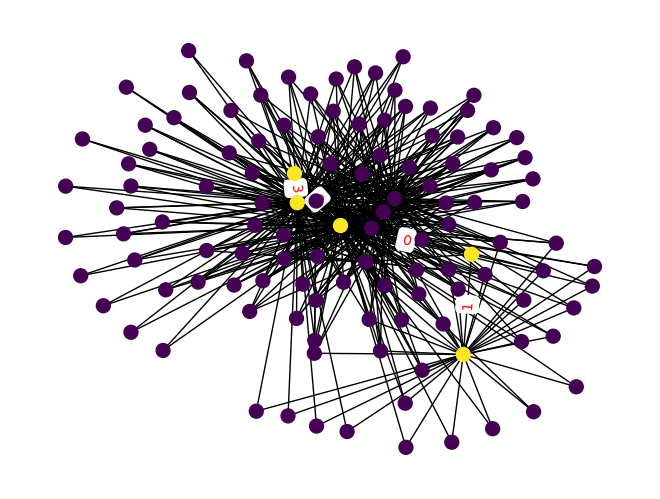

In [256]:
# nx.draw(tbd_graph)
import matplotlib.pyplot as plt
plt.figure()

nx.draw(tbd_graph, pos, node_color = cols, with_labels=False, node_size = 100)

nx.draw_networkx_edge_labels(tbd_graph, pos, edge_labels=path_edges, font_color='red')

In [ ]:
'SPIDER-MAN/PETER PAR','A 11', 'CAPTAIN AMERICA', 'A 101', 'UATU', 'CM 40','JONES, RICHARD MILHO'
test_h_seq = 'SPIDER-MAN/PETER PAR','CAPTAIN AMERICA', 'UATU', 'JONES, RICHARD MILHO'

# notes

In [ ]:
'''
cols = {}
for n in tbd_graph.nodes():
    cols[n] = 'blue'
    if n in ordered:
        cols[n] = 'red'

nx.set_node_attributes(tbd_graph, cols , name="color")
'''

In [ ]:
# recursion but won't to breadth first
'''
def shortest_path(v_i, v_f, hero_seq, visited, read, hero):
    
    if v_i == v_f:
        return visited, read
    else:
        c_iter = sub_comics.neighbors(v_i)
        for c in c_iter:
            for n in sub_comics.neighbors(c):
                if n in hero_seq and n not in visited:
                    break
                else:
                    new_visited = visited.copy().append(c, n)
                    new_read = read.copy().append(c)
                    new_hero = hero.copy().append(n)
                    shortest_path(n, v_f, new_visited, new_read, new_hero)
                    # paths.append(new_path)
                    # reads.append(new_read)
                        
'''


'''

visited = []
read = []
hero = []
h_0 = 'SPIDER-MAN/PETER PAR'
h_n = 'UATU'
test_h_seq = ['SPIDER-MAN/PETER PAR','CAPTAIN AMERICA', 'UATU', 'JONES, RICHARD MILHO']
test_h_seq_cop = test_h_seq.copy()

visited.append(h_0)
hero.append(h_0)

current = test_h_seq_cop.pop(0)

paths = map(lambda h: shortest_path(h, current, visited), hero)# for all visited heros search path to next hero in seq
c_iter = sub_comics.neighbors(current)
for c in c_iter:
    for n in sub_comics.neighbors(c):
        if n == h_n:
            path.append(c)
            path.append(n)
            path.append(c)
        
while current != h_n:
    for nodei


'''

In [ ]:
# testing
'''
visited_cp = visited.copy() # object?
path_cp = [v for v in visited.keys() if visited[v]==True] # visited.copy()

done = False

queue = []
for p in path_cp:
    queue.append([p])
#queue = queue + path_cp # queue.append(path_cp)
v_n = seq.pop(0)
print(v_n, seq)

while len(queue) != 0:
    curr_a = queue.pop(0) # path to first node considered
    curr = curr_a[-1] # current node
    print(curr_a)
    print(curr)
    if curr == v_n:
        done = True
        print('!!!')
        print(curr_a) # actual path of interest
        break
    
    for n in sub_comics.neighbors(curr):
        if visited_cp[n] == False and n not in seq:
            visited_cp[n] = True
            curr_n = curr_a.copy()
            curr_n.append(n)
            print(curr_n)

            queue.append(curr_n)
    
print('heros not connected'+curr+'xxx'+v_n)
'''
        

In [ ]:
# counting edges for each node
'''
nodes_edgecount = {}

for node in heroes.nodes():
    nodes_edgecount[node] = len(heroes.edges(node))
    
# max_nr_edges = max(nodes_edgecount.values())




node_tuple_weight = {}
for e in heroes.edges: # .edges() doesnt have the edge key and believe this is the third tuple entry necessary
    weight = 1-(nodes_edgecount[e[0]]+nodes_edgecount[e[1]])/(2*max_nr_edges)
    node_tuple_weight[(e[0], e[1], e[2])] = weight


'''